In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display
from sklearn.decomposition import PCA
pd.set_option('display.max_colwidth', -1)

# Loading data

In [3]:
DATA_FOLDER = 'habits/'
answers_file = "questionnaire_answers.csv"
questions_file = 'questions_table.csv'
subquestionnaire_file ="questionnaire-subhabit_table.csv"
questionnaire_file = "questionnaire_table.csv"

# load the data
questionnaire_answers= pd.read_csv(DATA_FOLDER + answers_file, sep=',', error_bad_lines=False, encoding = "utf-8").dropna()
questionnaire_questions= pd.read_csv(DATA_FOLDER + questions_file, sep=',', error_bad_lines=False, encoding = "utf-8").dropna()
questionnaire = pd.read_csv(DATA_FOLDER + questionnaire_file, sep=',', skiprows = 1, error_bad_lines=False, encoding = "utf-8").dropna()
subquestionnaire= pd.read_csv(DATA_FOLDER + subquestionnaire_file, sep=',', error_bad_lines=False, encoding = "utf-8").dropna()

# Exploring the data

In this part we remove the answers which are not complete. 

In [8]:
# Find the number of questions each user has answered per questionnaire
questionnaire_users_df = questionnaire_answers.groupby(['questionnaire identifier', 'user identifier']).size().reset_index()
questionnaire_users_df.head()

,questionnaire identifier,user identifier,0
0,1,114,12
1,1,316,1
2,1,321,12
3,1,325,12
4,1,327,12


In [16]:
# Find the number of questions in each questionnaire
questionnaire_questions_df = questionnaire_questions.groupby(['questionnaire identifier']).size().reset_index()
questionnaire_questions_df = questionnaire_questions_df.rename(columns={'0': '# of questions'})
questionnaire_questions_df.head()

,questionnaire identifier,0
0,1,12
1,2,7
2,4,8
3,5,4
4,7,3


In [17]:
questionnaires_num = 25
questions_num = []
for i in range(questionnaires_num + 1):
    try:
        questions_num.append(int(questionnaire_questions_df.loc[questionnaire_questions_df['questionnaire identifier'] == i][0]))
    except:
        questions_num.append(0)
        
incomplete_questionnaire =[]
for index, row in questionnaire_users_df.iterrows():
    # Compare if 
    if row[0] != questions_num[row['questionnaire identifier']]:
        incomplete_questionnaire.append(index)
        
print("There are {} incomplete questionnaire".format(len(incomplete_questionnaire)))

questionnaire_users_cp = questionnaire_users_df.copy()
removed = 0
for x in incomplete_questionnaire:
    try:
        questionnaire_users_cp = questionnaire_users_cp.drop(questionnaire_users_cp.index[x - removed])
        removed += 1
    except:
        print(str(x) + " not found")

print("The {} incomplete questionnaire were removed from the dataset".format(removed))

There are 66 incomplete questionnaire
The 66 incomplete questionnaire were removed from the dataset


In [18]:
# Find the number of completely filled questionnaires per questionnaire
questionnaire_users_cp.groupby(['questionnaire identifier']).size().sort_values(ascending=False)

questionnaire identifier
11    460
12    453
13    452
1     347
2     248
4     187
5     186
18    113
20    112
19    112
9     105
7     103
8     99 
22    72 
24    69 
23    69 
16    50 
15    50 
25    5  
dtype: int64

# Reliability

In [19]:
def create_student_questions_matrix(df):
    students = pd.Series(df['user identifier'], name='A').unique().tolist()
    questions = pd.Series(df['question identifier'], name='A').unique().tolist()
    students_questions = np.zeros(shape=(len(questions), len(students)))
    
    for index, row in df.iterrows():
        s = students.index(row['user identifier'])
        q = questions.index(row['question identifier'])
        
        students_questions[q][s] = row['score of the answer']
    
    return students_questions

In [20]:
def CronbachAlpha(itemscores):
    itemvars = itemscores.var(axis=1, ddof=1)
    tscores = itemscores.sum(axis=0)
    nitems = len(itemscores)

    return nitems / (nitems-1.) * (1 - itemvars.sum() / tscores.var(ddof=1))

### Calculate reliability per questionnaire

In [21]:
questionnaires = pd.Series(questionnaire_answers['questionnaire identifier'], name='A').unique().tolist()
questionnaires_CronbachAlpha = []

for q in questionnaires:
    c = CronbachAlpha(create_student_questions_matrix(questionnaire_answers[questionnaire_answers['questionnaire identifier'] == q]))
    questionnaires_CronbachAlpha.append(c)
    
for i in range(len(questionnaires)):
    print("reliability of questionnaire {} is {}".format(questionnaires[i],questionnaires_CronbachAlpha[i]))

reliability of questionnaire 1 is 0.8689709750836196
reliability of questionnaire 2 is 0.580399580124851
reliability of questionnaire 4 is 0.7649848361130397
reliability of questionnaire 5 is 0.7483906904142549
reliability of questionnaire 7 is 0.37251548664158374
reliability of questionnaire 8 is 0.614920377320215
reliability of questionnaire 11 is 0.5297423133854757
reliability of questionnaire 12 is 0.6608979593374414
reliability of questionnaire 13 is -0.36924436369456226
reliability of questionnaire 22 is 0.7355681629299287
reliability of questionnaire 23 is 0.848671024265258
reliability of questionnaire 24 is 0.6064659062935914
reliability of questionnaire 18 is 0.7108593638168498
reliability of questionnaire 19 is 0.7000261220021893
reliability of questionnaire 20 is 0.6690401373719836
reliability of questionnaire 15 is 0.9086912746919268
reliability of questionnaire 16 is 0.8689867473651257
reliability of questionnaire 9 is 0.4805951157441393
reliability of questionnaire 25 is 

# Validity

In [22]:
def get_infos(q_id, get_corr = True):
    # 
    qt, qtt, is_sub = get_table(q_id)
    title = ""
    if (is_sub):
        title = subquestionnaire.loc[subquestionnaire['subhabit identifier'] == q_id]['subhabit title'].iloc[0]    
    else:
        title = questionnaire.loc[questionnaire['questionnaire identifier'] == q_id]['questionnaire title'].iloc[0]
    print("Reliability for questionnaire", title, "is:", compute_cronbach(qt))
    if (get_corr):
        corr, corr_map = compute_corr(qt)
        corr_map.set_title(title)
        plt.show()
        display(corr.round(decimals=2))
    return qt, qtt
        
def get_questions(q_id):
    # Returns the number of questions as well as the answers to those questions.
    is_sub = False
    is_split = list(subquestionnaire['reference habit identifier'])
    is_sub_id = list(subquestionnaire['subhabit identifier'])
    if (q_id in is_sub_id):
        is_sub = True
    list_q = []
    if (q_id in is_split):
        list_q= list(subquestionnaire.loc[subquestionnaire['reference habit identifier'] == q_id]['subhabit identifier'])
    else:
        list_q.append(q_id)
        
    nb_q_per_q = questionnaire_questions.groupby(['questionnaire identifier']).size().reset_index().rename(columns={0:'records'})
    number_questions = 0
    frames = []
    for l in list_q:
        q_tmp = questionnaire_answers.loc[questionnaire_answers['questionnaire identifier'] == l]
        frames.append(q_tmp)
        number_questions += int(nb_q_per_q.loc[nb_q_per_q['questionnaire identifier'] == l]['records'])
    q_answers = pd.concat(frames)
    return number_questions, q_answers, is_sub
    
def get_table(q_id):
    # Returns the table user/question for the users that completed the entire questionnaire (each row is a user, each column a question)
    # Also returns the list of said questions (text)
    nb_quest, q, is_sub = get_questions(q_id)
    users = q.groupby(['user identifier']).size().reset_index().rename(columns={0:'records'})
    users = users.loc[users['records'] == nb_quest]
    
    frames = []
    i=0
    for u in users['user identifier']:
        u_tmp = q.loc[q['user identifier'] == u][['question identifier', 'score of the answer']].reset_index()[['score of the answer']].T
        frames.append(u_tmp)
        q_table = q.loc[q['user identifier'] == u][['question identifier']]
    questions_table = pd.concat(frames)
    
    frames = []
    for r in q_table['question identifier']:
        r_tmp = questionnaire_questions.loc[questionnaire_questions['question identifier'] == r][['text', 'questionnaire identifier']]
        frames.append(r_tmp)
    questions_text = pd.concat(frames).reset_index()
    
    return questions_table, questions_text, is_sub

def compute_cronbach(questions_table):
    nn = np.array(questions_table.T)
    nn[np.logical_not(np.isfinite(nn))] = 0
    return CronbachAlpha(nn)

def compute_corr(questions_table):    
    corr = questions_table.corr()
    return corr, sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)

Reliability for questionnaire Auto-régulation is: 0.7283736532105566


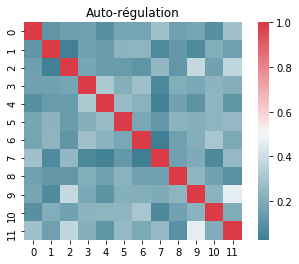

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.00,0.12,0.16,0.16,0.10,0.18,0.17,0.29,0.16,0.18,0.10,0.29
1,0.12,1.00,0.04,0.16,0.14,0.24,0.24,0.08,0.13,0.07,0.21,0.16
2,0.16,0.04,1.00,0.18,0.14,0.14,0.12,0.25,0.12,0.38,0.17,0.38
3,0.16,0.16,0.18,1.00,0.32,0.22,0.28,0.06,0.21,0.19,0.24,0.21
4,0.10,0.14,0.14,0.32,1.00,0.26,0.23,0.04,0.17,0.11,0.24,0.12
5,0.18,0.24,0.14,0.22,0.26,1.00,0.18,0.13,0.23,0.22,0.24,0.26
6,0.17,0.24,0.12,0.28,0.23,0.18,1.00,0.03,0.16,0.22,0.31,0.19
7,0.29,0.08,0.25,0.06,0.04,0.13,0.03,1.00,0.16,0.20,0.07,0.26
8,0.16,0.13,0.12,0.21,0.17,0.23,0.16,0.16,1.00,0.24,0.17,0.10
9,0.18,0.07,0.38,0.19,0.11,0.22,0.22,0.20,0.24,1.00,0.23,0.47


Number of users:  347 
No subquestionnaire


,text
0,"En classe, je manque souvent des points importants parce que je pense à autre chose."
1,"Lorsque je lis un document pour ce cours, je prépare des questions pour m’aider à cibler ma lecture."
2,"Lorsque je lis un document pour ce cours et que le contenu devient confus, je reviens en arrière et j’essaie de le comprendre."
3,"Si les documents du cours sont difficiles à comprendre, je change de technique de lecture."
4,"Avant d’étudier un nouveau document du cours en détails, je commence souvent par le parcourir rapidement pour voir comment il est organisé."
5,Je me pose des questions à moi-même pour être sûr que je comprends la matière que j’ai étudiée dans ce cours.
6,J’essaie de changer la façon dont j’étudie pour m’adapter aux spécificités du cours et à la façon dont l’enseignant·e enseigne.
7,"Je constate souvent que même si j’ai relu les documents du cours avant la classe, je ne sais plus ce dont il s’agissait."
8,"Lorsque j’étudie pour ce cours, j’essaie d’analyser les sujets et décider ce que je dois en retenir plutôt que de simplement relire les documents du cours attentivement."
9,"Lorsque j’étudie pour ce cours, j’essaie d’identifier les concepts que je n’ai pas bien compris."


,0,1,2,3,4,5,6,7,8,9,10,11
count,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000
mean,4.870317,2.602305,6.023055,3.942363,4.668588,4.377522,4.319885,4.899135,4.694524,5.599424,4.365994,5.190202
std,1.595844,1.561012,1.150290,1.697369,1.791831,1.680855,1.679090,1.649549,1.637370,1.206102,1.681692,1.449982
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,1.000000,6.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,5.000000,3.000000,4.000000
50%,5.000000,2.000000,6.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,5.000000,5.000000
75%,6.000000,3.000000,7.000000,5.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [23]:
qt, qtt = get_infos(1)
print("Number of users: ", qt.shape[0], "\nNo subquestionnaire")
display(qtt[['text']])
display(qt.describe())

Reliability for questionnaire Révision is: 0.5519855831103058


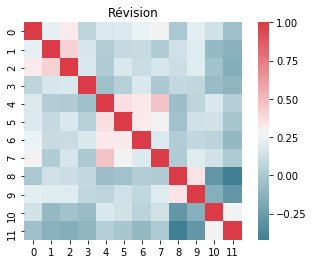

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.00,0.23,0.32,0.07,0.19,0.19,0.24,0.27,-0.00,0.21,0.15,-0.04
1,0.23,1.00,0.41,0.17,0.03,0.10,0.11,0.02,0.14,0.21,-0.08,-0.14
2,0.32,0.41,1.00,0.18,0.02,0.18,0.12,0.16,0.12,0.21,-0.03,-0.15
3,0.07,0.17,0.18,1.00,-0.04,0.05,0.18,0.01,0.09,0.09,-0.07,-0.11
4,0.19,0.03,0.02,-0.04,1.00,0.36,0.32,0.47,-0.06,0.07,0.18,0.04
5,0.19,0.10,0.18,0.05,0.36,1.00,0.32,0.27,-0.04,0.14,0.15,-0.01
6,0.24,0.11,0.12,0.18,0.32,0.32,1.00,0.19,0.03,0.09,0.06,-0.09
7,0.27,0.02,0.16,0.01,0.47,0.27,0.19,1.00,0.02,0.20,0.15,0.01
8,-0.00,0.14,0.12,0.09,-0.06,-0.04,0.03,0.02,1.00,0.35,-0.28,-0.42
9,0.21,0.21,0.21,0.09,0.07,0.14,0.09,0.20,0.35,1.00,-0.14,-0.28


Number of users:  451 
Subquestionnaires: Faire des liens, Organiser les idées, Pratiquer le rappel
Reliability for questionnaire Faire des liens is: 0.5231711668083708
Reliability for questionnaire Organiser les idées is: 0.6621419876946018
Reliability for questionnaire Pratiquer le rappel is: -0.36953432459691654


,text
0,"Lorsque j’étudie pour ce cours, je rassemble des informations provenant de différentes sources, comme mes notes de cours, les documents recommandés et les discussions."
1,"Lorsque je fais un exercice, j’essaie de voir en quoi il est relié aux concepts et idées du cours."
2,J’essaie de comprendre le contenu du cours en faisant des liens entre ce que j’ai lu et les concepts vus en classe.
3,J’essaie de voir comment les exercices sont reliés à des applications de la vie réelle.
4,"Lorsque j’étudie pour ce cours, je rédige de courts résumés des éléments essentiels."
5,"Lorsque j’étudie les documents pour ce cours, je fais un plan du contenu pour m’aider à organiser mes idées."
6,"Je fais des diagrammes, des schémas ou des tableaux pour m’aider à organiser le contenu du cours."
7,"Lorsque j’étudie pour ce cours, je passe en revue mes notes de cours et je fais une liste des concepts importants."
8,"Quand je travaille sur les exercices de ce cours, j’essaie en général de me souvenir au maximum du contenu du cours avant de regarder mes notes."
9,J’essaie de me tester pour voir si j’arrive à me rappeler des idées clés du cours.


,0,1,2,3,4,5,6,7,8,9,10,11
count,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.00000,451.000000,451.000000,451.000000
mean,5.159645,5.432373,5.407982,4.470067,3.975610,3.729490,4.363636,4.791574,5.04878,4.931264,4.421286,3.288248
std,1.441069,1.289864,1.303782,1.715515,2.029084,1.793196,1.785350,1.633271,1.61309,1.574004,1.880872,1.575174
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
25%,4.000000,5.000000,5.000000,3.000000,2.000000,2.000000,3.000000,4.000000,4.00000,4.000000,3.000000,2.000000
50%,5.000000,6.000000,6.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.00000,5.000000,5.000000,3.000000
75%,6.000000,6.000000,6.000000,6.000000,6.000000,5.000000,6.000000,6.000000,6.00000,6.000000,6.000000,4.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.00000,7.000000,7.000000,7.000000


In [24]:
qt, qtt= get_infos(10)
print("Number of users: ", qt.shape[0], "\nSubquestionnaires: Faire des liens, Organiser les idées, Pratiquer le rappel")
get_infos(11, get_corr=False)
get_infos(12, get_corr=False)
get_infos(13, get_corr=False)
display(qtt[['text']].style.apply(lambda x: ['background: lightgreen' if i < 4 else '' for i, _ in enumerate(x)])
.apply(lambda x : ['background: lightyellow' if i >= 4 and i < 8 else '' for i, _ in enumerate(x)])
.apply(lambda x : ['background: lightblue' if i >= 8 else '' for i, _ in enumerate(x)]))
display(qt.describe())

Reliability for questionnaire Aide et soutien is: 0.903908243857503


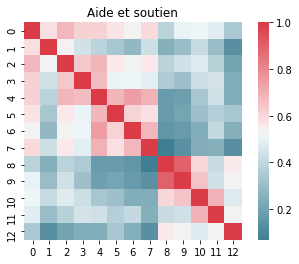

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.00,0.58,0.68,0.61,0.61,0.57,0.52,0.60,0.38,0.50,0.51,0.48,0.34
1,0.58,1.00,0.52,0.44,0.39,0.33,0.29,0.43,0.25,0.30,0.41,0.30,0.14
2,0.68,0.52,1.00,0.64,0.69,0.56,0.54,0.56,0.38,0.44,0.47,0.38,0.21
3,0.61,0.44,0.64,1.00,0.67,0.51,0.51,0.48,0.35,0.31,0.43,0.45,0.24
4,0.61,0.39,0.69,0.67,1.00,0.68,0.75,0.69,0.18,0.19,0.34,0.44,0.24
5,0.57,0.33,0.56,0.51,0.68,1.00,0.61,0.58,0.18,0.21,0.31,0.37,0.34
6,0.52,0.29,0.54,0.51,0.75,0.61,1.00,0.68,0.16,0.17,0.24,0.41,0.25
7,0.60,0.43,0.56,0.48,0.69,0.58,0.68,1.00,0.07,0.14,0.24,0.25,0.13
8,0.38,0.25,0.38,0.35,0.18,0.18,0.16,0.07,1.00,0.90,0.60,0.41,0.55
9,0.50,0.30,0.44,0.31,0.19,0.21,0.17,0.14,0.90,1.00,0.65,0.44,0.54


Number of users:  50 
Subquestionnaire: Soutien des camarades, Soutien des enseignant-e-s
Reliability for questionnaire Soutien des camarades is: 0.9044221226209739
Reliability for questionnaire Soutien des enseignant-e-s is: 0.8689867473651257


,text
0,Je peux contacter d'autres étudiants de ma classe si j’ai des questions sur un travail à faire.
1,Les autres étudiants m’aident en me rappelant lorsque des travaux doivent être rendus ou quand un test approche.
2,"Si je manque un cours, je connais des étudiants qui pourraient me donner leurs notes."
3,Je retrouve des étudiants de ma classe en dehors des cours pour étudier.
4,Je discute avec les étudiants de ma classe d’événements qui se passent en dehors des cours.
5,"J’invite des étudiants de ma classe pour des activités, des loisirs ou des sorties en dehors des cours."
6,J’ai lié amitié avec d’autres étudiants de ma classe.
7,Il m’est arrivé de discuter de sujets personnels avec des étudiants de ma classe.
8,Je me sens à l’aise pour demander de l’aide à l’enseignant avant ou après le cours.
9,Je me sens à l’aise pour demander de l’aide à l’enseignant si je ne comprends pas quelque-chose en lien avec le cours.


,0,1,2,3,4,5,6,7,8,9,10,11,12
count,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00
mean,5.60,4.76,6.16,4.76,5.54,4.72,5.74,5.38,4.98,5.22,5.74,4.72,4.38
std,1.81,1.71,1.09,2.01,1.70,1.92,1.41,1.74,1.61,1.58,1.54,1.80,1.90
min,1.00,1.00,2.00,1.00,1.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,5.00,4.00,6.00,3.25,5.00,3.00,5.00,5.00,4.00,4.00,5.00,4.00,3.00
50%,6.00,5.00,6.50,5.00,6.00,5.00,6.00,6.00,5.00,6.00,6.00,5.00,4.50
75%,7.00,6.00,7.00,6.00,7.00,6.00,7.00,7.00,6.00,6.00,7.00,6.00,6.00
max,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00


In [25]:
qt, qtt = get_infos(14)
print("Number of users: ", qt.shape[0], "\nSubquestionnaire: Soutien des camarades, Soutien des enseignant-e-s")
get_infos(15, get_corr=False)
get_infos(16, get_corr=False)
display(qtt[['text']].style.apply(lambda x: ['background: lightgreen' if i < 8 else 'background: lightyellow' for i, _ in enumerate(x)]))
display(qt.describe().round(decimals=2))

# PCA

#### Questionnaire 14

In [27]:
pca_2 = PCA(n_components=2)
df15 = questionnaire_answers[questionnaire_answers['questionnaire identifier'] == 15]
df16 = questionnaire_answers[questionnaire_answers['questionnaire identifier'] == 16]
df_row_reindex = pd.concat([df15, df16], ignore_index=True)
q14_data = create_student_questions_matrix(df_row_reindex)
pca_2.fit(q14_data)
print("Explained variance ratio with two subscales:")
print(pca_2.explained_variance_ratio_)
print("Singular values of two subscales:")
print(pca_2.singular_values_)  

Explained variance ratio with two subscales:
[0.30363272 0.16690825]
Singular values of two subscales:
[19.83939084 14.70933222]


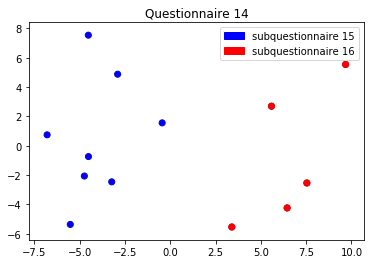

In [40]:
# Mapping the questions to 2D space
q14_transformed = PCA(n_components=2).fit_transform(q14_data)
import matplotlib.pyplot as plt
color = [1,1,1,1,1,1,1,1,0,0,0,0,0]

plt.scatter(q14_transformed[:,0],q14_transformed[:,1] ,c=color)
color_q10 = ["blue","blue","blue","blue","blue","blue","blue","blue","red","red","red","red","red"]

red_patch = mpatches.Patch(color='red', label='subquestionnaire 16')
blue_patch = mpatches.Patch(color='blue', label='subquestionnaire 15')
plt.title('Questionnaire 14')
plt.scatter(q14_transformed[:,0],q14_transformed[:,1] ,c=color_q10)
plt.legend(handles=[blue_patch,red_patch])
plt.show()

plt.show()

#### Questionnaire 10

In [32]:
# Create a Covariance Matrix
questions_num = 12
pca_3 = PCA(n_components=questions_num)
df11 = questionnaire_answers[questionnaire_answers['questionnaire identifier'] == 11]
df12 = questionnaire_answers[questionnaire_answers['questionnaire identifier'] == 12]
df13 = questionnaire_answers[questionnaire_answers['questionnaire identifier'] == 13]
df_11_12 = pd.concat([df11, df12], ignore_index=True)
df_11_12_13 = pd.concat([df_11_12, df13], ignore_index=True)

q10_data = create_student_questions_matrix(df_11_12_13)

# Calculate Eigenvalues
pca_3.fit(q10_data) 

PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [34]:
# calculate variance ratios
print("Explained variance ratio:")
print(pca_3.explained_variance_ratio_)

print("cumulative sum of variance explained with 12 features:")
var=np.cumsum(np.round(pca_3.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with 12 features

Explained variance ratio:
[2.87321983e-01 1.32180581e-01 1.10164344e-01 9.71748642e-02
 7.37631255e-02 7.11644348e-02 6.01869396e-02 5.39350175e-02
 4.52293489e-02 4.06733208e-02 2.82060401e-02 6.60971581e-32]
cumulative sum of variance explained with 12 features:


array([28.7, 41.9, 52.9, 62.6, 70. , 77.1, 83.1, 88.5, 93. , 97.1, 99.9,
       99.9])

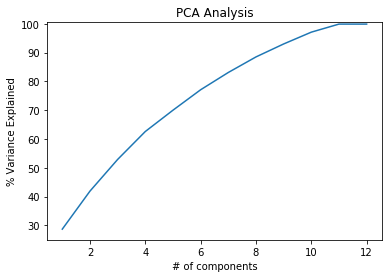

In [35]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of components')
plt.title('PCA Analysis')
plt.ylim(25,100.5)
plt.style.context('seaborn-whitegrid')


plt.plot(range(1,13),var)

<BarContainer object of 12 artists>

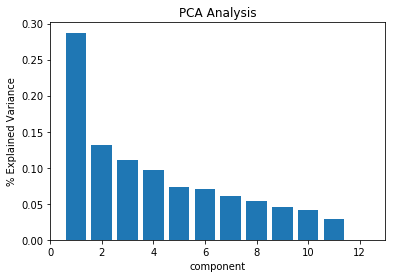

In [37]:
plt.ylabel('% Explained Variance')
plt.xlabel('component')
plt.title('PCA Analysis')
plt.bar(range(1,13),pca_3.explained_variance_ratio_)

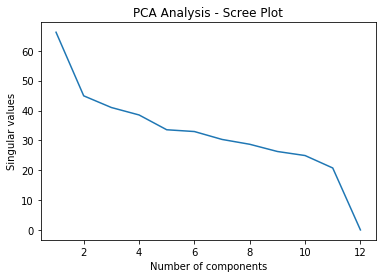

In [38]:
plt.ylabel('Singular values')
plt.xlabel('Number of components')
plt.title('PCA Analysis - Scree Plot')
plt.style.context('seaborn-whitegrid')

plt.plot(range(1,13),pca_3.singular_values_)

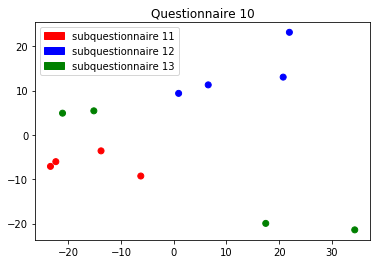

In [41]:
# mapping the questions to 2D space
q10_transformed = PCA(n_components=2).fit_transform(q10_data)
color_q10 = ['red','red','red','red','blue','blue','blue','blue','green','green','green','green']
color_label = ['','sub_questionnaire 12','sub_questionnaire 11','purple']

plt.scatter(q10_transformed[:,0],q10_transformed[:,1] ,c=color_q10)
red_patch = mpatches.Patch(color='red', label='subquestionnaire 11')
blue_patch = mpatches.Patch(color='blue', label='subquestionnaire 12')
green_patch = mpatches.Patch(color='green', label='subquestionnaire 13')
plt.title('Questionnaire 10')
plt.legend(handles=[red_patch,blue_patch,green_patch])
plt.show()
